In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt

from femsolver.jax_utils import auto_vmap, vmap
from femsolver.quadrature import quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator

In [2]:
# --- Nonlinear material model: Neo-Hookean (plane strain) ---
def neo_hookean_energy(F, mu=1.0, lmbda=1.0):
    J = jnp.linalg.det(F)
    Ic = jnp.trace(F.T @ F)
    return (mu / 2) * (Ic - 2) - mu * jnp.log(J) + (lmbda / 2) * (jnp.log(J))**2

def compute_energy_nl(u_grad, mu=1.0, lmbda=1.0):
    F = u_grad + jnp.eye(2)
    return neo_hookean_energy(F, mu, lmbda)

In [3]:
# --- Mesh generation (reuse from linear example) ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

In [10]:
# --- Newton-Raphson solver ---
def solve_fem_nonlinear(max_iter=20, tol=1e-8):
    coords, elements = generate_unit_square_mesh_tri(4, 2)
    n_nodes = coords.shape[0]
    n_dofs = 2 * n_nodes
    u = jnp.zeros(n_dofs)

    fem = FemOperator(
        compute_quads=quad_tri3,
        compute_shape_fn=shape_fn_tri3,
        compute_energy=compute_energy_nl,
    )

    def total_energy(u_flat, coords, elements, fem):
        u = u_flat.reshape(-1, 2)
        u_cell = u[elements]
        x_cell = coords[elements]
        return jnp.sum(fem.integrate(u_cell, x_cell))

    grad_E = jax.grad(total_energy)
    hess_E = jax.jacfwd(jax.grad(total_energy))

    # Dirichlet BCs: fix left, displace right
    left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
    right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
    fixed_dofs = jnp.concatenate([
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ])
    prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.02)  # Larger displacement for nonlinearity
    free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

    # Newton-Raphson loop
    u_full = prescribed_values.copy()
    for i in range(max_iter):
        f_int = grad_E(u_full, coords, elements, fem)
        K = hess_E(u_full, coords, elements, fem)
        f_ext = -f_int - K @ prescribed_values
        res = f_ext[free_dofs]
        K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
        norm_res = jnp.linalg.norm(res)
        print(f"Newton iter {i}: |res| = {norm_res:.3e}")
        if norm_res < tol:
            break
        du = jnp.linalg.solve(K_reduced, res)
        u_full = u_full.at[free_dofs].add(du)
    else:
        print("Warning: Newton did not converge")

    return coords, u_full.reshape(-1, 2), elements

In [25]:
# --- Newton-Raphson solver with incremental loading ---
def solve_fem_nonlinear_incremental(
    max_iter=20, tol=1e-8, n_steps=50, total_disp=0.2, alpha=1.0
):
    coords, elements = generate_unit_square_mesh_tri(10, 2)
    n_nodes = coords.shape[0]
    n_dofs = 2 * n_nodes
    u_full = jnp.zeros(n_dofs)

    fem = FemOperator(
        compute_quads=quad_tri3,
        compute_shape_fn=shape_fn_tri3,
        compute_energy=compute_energy_nl,
    )

    def total_energy(u_flat, coords, elements, fem):
        u = u_flat.reshape(-1, 2)
        u_cell = u[elements]
        x_cell = coords[elements]
        return jnp.sum(fem.integrate(u_cell, x_cell))

    grad_E = jax.grad(total_energy)
    hess_E = jax.jacfwd(jax.grad(total_energy))

    left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
    right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
    fixed_dofs = jnp.concatenate(
        [
            2 * left_nodes,
            2 * left_nodes + 1,
            2 * right_nodes,
        ]
    )
    free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

    for step in range(n_steps):
        disp = total_disp * (step + 1) / n_steps
        prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(disp)
        print(f"\nLoad step {step+1}/{n_steps}, prescribed disp = {disp:.4f}")
        for i in range(max_iter):
            f_int = grad_E(u_full, coords, elements, fem)
            K = hess_E(u_full, coords, elements, fem)
            f_ext = -f_int - K @ prescribed_values
            res = f_ext[free_dofs]
            K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
            norm_res = jnp.linalg.norm(res)
            print(f"  Newton iter {i}: |res| = {norm_res:.3e}")
            if norm_res < tol:
                break
            du = jnp.linalg.solve(K_reduced, res)
            u_full = u_full.at[free_dofs].add(alpha * du)
            if not jnp.all(jnp.isfinite(u_full)):
                print("  NaN detected, stopping iteration.")
                break
        else:
            print("  Warning: Newton did not converge at this load step")
        # After each step, update u_full for the next step
        u_full = prescribed_values.at[free_dofs].set(u_full[free_dofs])

    return coords, u_full.reshape(-1, 2), elements


In [26]:
# --- Visualization ---
def plot_deformed_mesh(coords, u, elements, scale=1.0):
    displaced = coords + scale * u
    plt.figure(figsize=(10, 5))
    plt.triplot(displaced[:, 0], displaced[:, 1], elements, color="gray", alpha=0.7)
    plt.triplot(coords[:, 0], coords[:, 1], elements, color="blue", alpha=0.3)
    plt.title("Deformed (gray) and undeformed (blue) mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

Newton iter 0: |res| = 2.704e-01
Newton iter 1: |res| = 1.032e-02
Newton iter 2: |res| = 1.126e-03
Newton iter 3: |res| = 1.269e-04
Newton iter 4: |res| = 1.434e-05
Newton iter 5: |res| = 1.620e-06
Newton iter 6: |res| = 1.831e-07
Newton iter 7: |res| = 2.069e-08
Newton iter 8: |res| = 2.339e-09


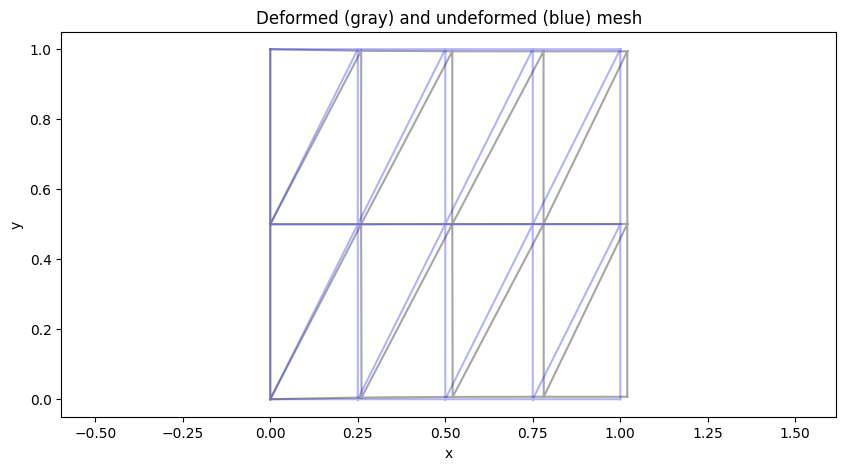

In [31]:
# --- Run nonlinear FEM ---
coords, u, elements = solve_fem_nonlinear()
plot_deformed_mesh(coords, u, elements, scale=1.0)